# Import libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Data analysis

In [73]:
fileroute = 'https://github.com/U20212419/TA_TACC/blob/main/corpus.csv?raw=true'
raw_dataset = pd.read_csv(fileroute, delimiter=',', encoding='latin-1')

In [74]:
raw_dataset.head()

,title,text
0,Utush Kuru,Unayshi kay shumaq pampachaw papata muruq huk ...
1,Wayllukuypa churapanakuynin,"Unayshi huk markachaw, huk musu runa shipash w..."
2,Ashnuwan tuuru shnuwan tuuru,Huk patsashi karqan runakuna uywakunatashi rim...
3,Kalishtu Garmendia,"Markachaw, Kashpi llaqllaq, Kalishtu Garmendia..."
4,Ñuku kurushi,"Unayshi, huk kutishi patsachaw, hanan patsawan..."


Central quechua consists of 24 letters or spellings:

6 vocals: a, i, u, aa, ii, uu

18 consonants: ch, h, k, l, ll, m, n, ñ, p, q, r, s, sh, t, ts, tr, w, y.

https://cdn.www.gob.pe/uploads/document/file/5008213/manual-escritura-lengua-quechua-central-comprimido.pdf?v=1692305602

In [75]:
alphabet = ['a', 'i', 'u', 'aa', 'ii', 'uu', 'ch', 'h', 'k', 'l', 'll', 'm', 'n', 'ñ', 'p', 'q', 'r', 's', 'sh', 't', 'ts', 'tr', 'w', 'y']
punctuation = ['.', ',', '!', '?', ':', ';', '-', '(', ')', '[', ']', '{', '}', '"', "'", '...', '–', '—', '“', '”', '‘', '’', '¡', '¿', '…', '«', '»', "_"]
print("Alphabet length: {}".format(len(alphabet)))

# Regex to detect words that contain spellings that aren't in the alphabet
alphabet_pattern = '|'.join(re.escape(char) for char in alphabet + punctuation)
pattern = f'^(?:{alphabet_pattern})+$'
print("Regex: {}".format(pattern))

Alphabet length: 24
Regex: ^(?:a|i|u|aa|ii|uu|ch|h|k|l|ll|m|n|ñ|p|q|r|s|sh|t|ts|tr|w|y|\.|,|!|\?|:|;|\-|\(|\)|\[|\]|\{|\}|"|'|\.\.\.|–|—|“|”|‘|’|¡|¿|…|«|»|_)+$


In [76]:
def is_valid_word(word):
        return bool(re.match(pattern, word, re.IGNORECASE))

def filter_text(text):
    words = text.split()
    valid_words = filter(is_valid_word, words)
    return ' '.join(valid_words)

def remove_foreign_spellings(dataset):
    # Remove words with foreign spellings
    dataset['text'] = dataset['text'].apply(filter_text)
    dataset['title'] = dataset['title'].apply(filter_text)

    dataset = dataset[dataset['text'].str.strip().astype(bool)]
    dataset = dataset[dataset['title'].str.strip().astype(bool)]

dataset = raw_dataset.copy()
remove_foreign_spellings(dataset)
dataset.head()

,title,text
0,Utush Kuru,Unayshi kay shumaq pampachaw papata muruq huk ...
1,Wayllukuypa churapanakuynin,"Unayshi huk markachaw, huk musu runa shipash w..."
2,Ashnuwan tuuru shnuwan tuuru,Huk patsashi karqan runakuna uywakunatashi rim...
3,Kalishtu,"Markachaw, Kashpi llaqllaq, Kalishtu achka huc..."
4,Ñuku kurushi,"Unayshi, huk kutishi patsachaw, hanan patsawan..."


RAW DATASET


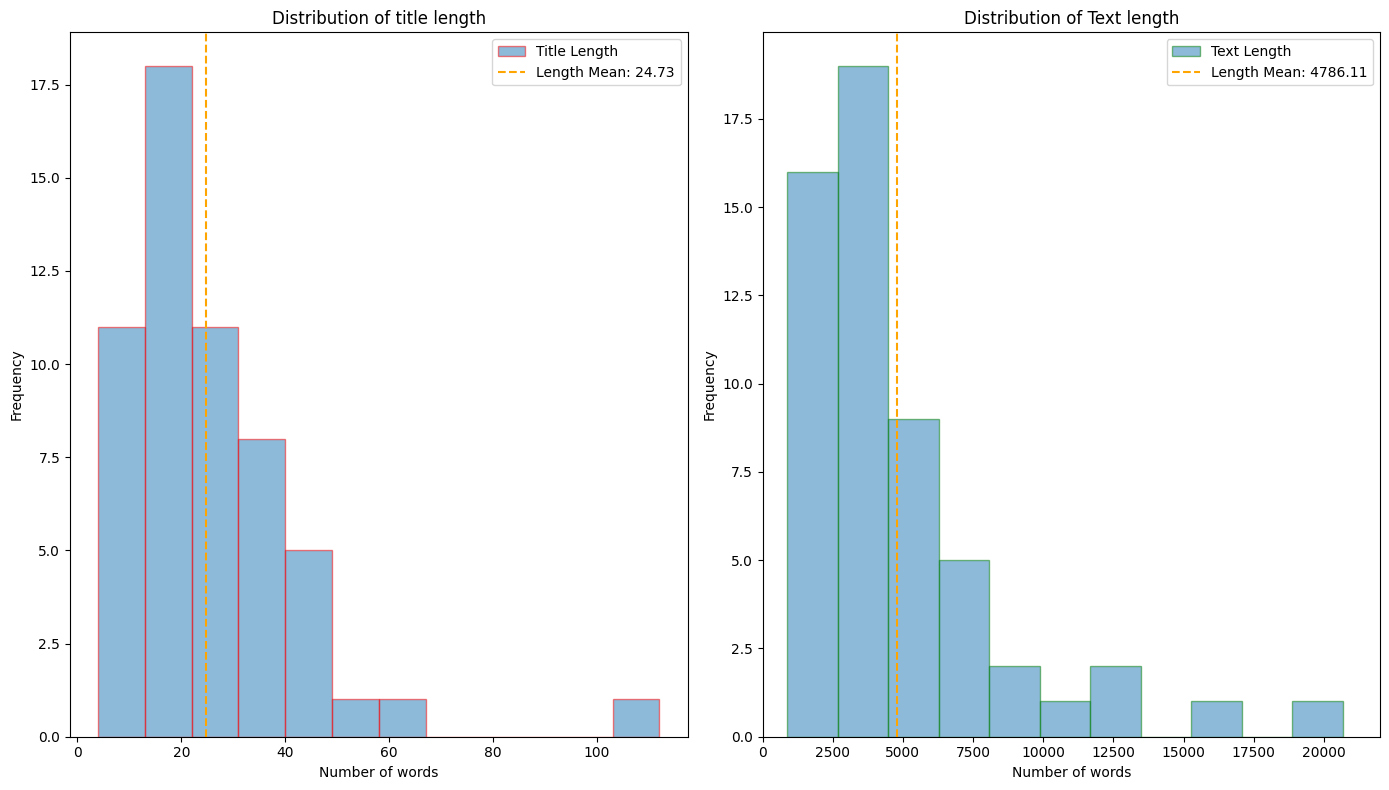


FILTERED DATASET


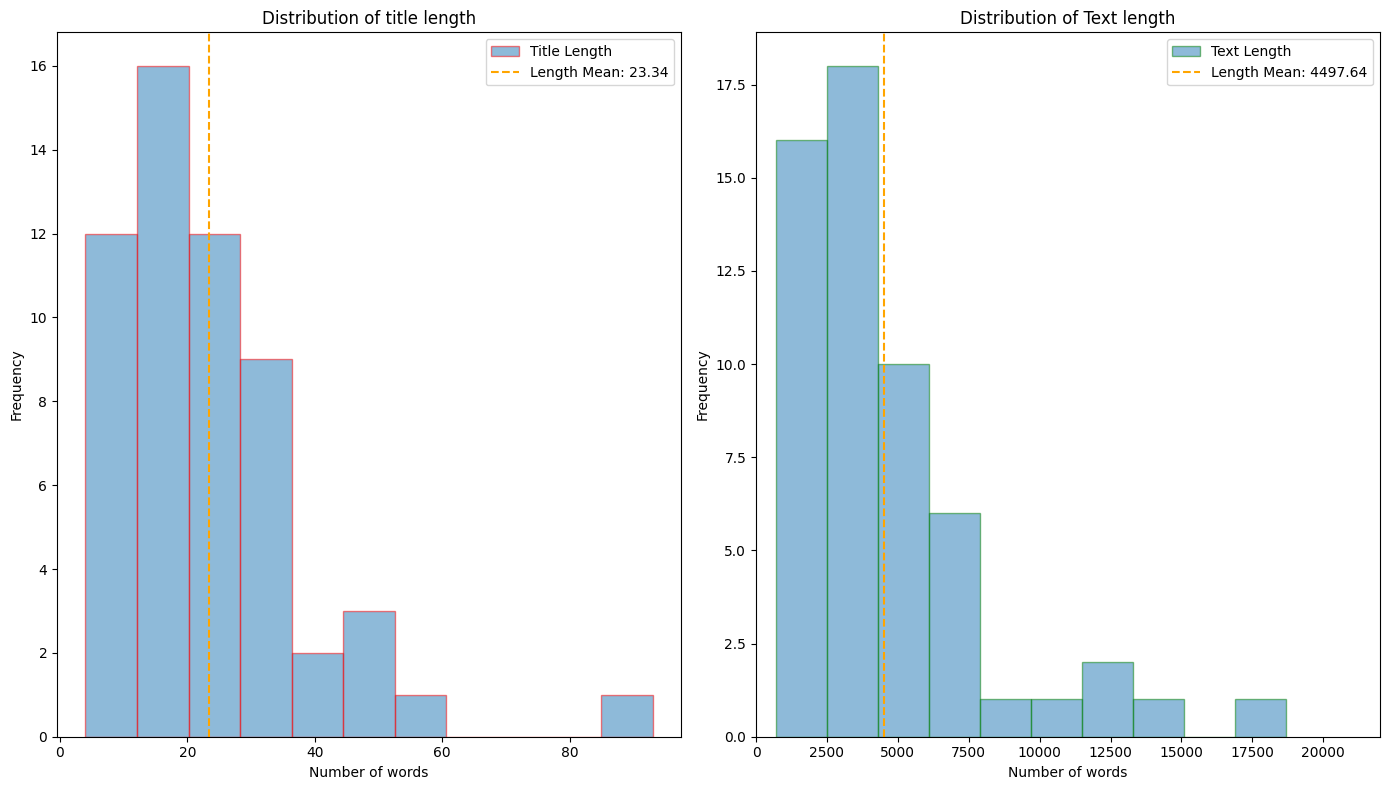

In [77]:
def freedman_diaconis_bins(data):
    '''Calculate the number of bins using the Freedman-Diaconis rule.'''
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    bin_width = 2 * iqr / np.power(n, 1/3)
    num_bins = int(np.ceil((np.max(data) - np.min(data)) / bin_width))
    return num_bins

def text_length_analysis(dataset):
    # Text length analysis
    dataset['text_length'] = dataset['text'].apply(len)
    dataset['title_length']   = dataset['title'].apply(len)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))

    text_mean = np.mean(dataset['text_length'])
    title_mean   = np.mean(dataset['title_length'])

    ax1.hist(dataset['title_length'], label='Title Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['title_length']), edgecolor='red')
    ax1.axvline(title_mean, color='orange', linestyle='--', label=f"Length Mean: {title_mean:.2f}")
    ax1.set_xlabel('Number of words')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of title length')
    ax1.legend()

    ax2.hist(dataset['text_length'], label='Text Length', alpha=0.5, bins=freedman_diaconis_bins(dataset['text_length']), edgecolor='green')
    ax2.axvline(text_mean, color='orange', linestyle='--', label=f"Length Mean: {text_mean:.2f}")
    ax2.set_xlabel('Number of words')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Text length')
    ax2.set_xlim([0,22000])
    ax2.legend()

    plt.tight_layout()
    plt.xlim([0, 22000])
    plt.show()

print("RAW DATASET")
text_length_analysis(raw_dataset)

print("\nFILTERED DATASET")
text_length_analysis(dataset)

# Define model

In [78]:
import keras.utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = dataset['text'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

# Create input and output sequences
input_sequences = []
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Sequence padding
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create X (input sequences) and y (target words)
input_sequences = np.array(input_sequences)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = keras.utils.to_categorical(y, num_classes=total_words)

In [84]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam

# Example model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.05), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1891, 50)          597800    
                                                                 
 lstm_4 (LSTM)               (None, 100)               60400     
                                                                 
 dense_4 (Dense)             (None, 11956)             1207556   
                                                                 
Total params: 1865756 (7.12 MB)
Trainable params: 1865756 (7.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Fit model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = keras.callbacks.ModelCheckpoint('model.h5', monitor='accuracy', save_best_only=True, verbose=1)
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, verbose=1)

train_sh = model.fit(
    X, y,
    epochs=20,
    callbacks=[checkpoint, earlystopping],
    batch_size=64,
    verbose=1
)

# Evaluation of the model

In [ ]:
epochs = np.arange(1, len(train_sh.history['accuracy']) + 1)

# Plot the training and validation accuracies
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(epochs, train_sh.history['accuracy'], label='Training Accuracy')
ax1.plot(epochs, train_sh.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracies')

# Plot the training and validation losses
ax2.plot(epochs, train_sh.history['loss'], label='Training Loss')
ax2.plot(epochs, train_sh.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Losses')

# Show the legend
plt.legend()
plt.show()

# Model testing

In [ ]:
# Load best saved model
model = keras.models.load_model('model.h5')

In [ ]:
def generate_text(seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

seed_text = "Unayshi kay shumaq"
next_words = 50
print(generate_text(seed_text, next_words, max_sequence_len))